# 비트코인 트레이딩 전략 - 딥러닝 모델 개발 과제 💰

**학생 정보**
- 이름:
- 학번:
- 제출일:

---

## 📋 과제 목표

**가격 변화 방향을 예측하는 딥러닝 모델과 트레이딩 전략을 개발하여 Buy and Hold 벤치마크를 초과하는 수익률을 달성하세요!**

### 과제 요구사항

1. **딥러닝 모델 개발** (핵심)
   - 가격 상승(1) / 하락(0)을 예측하는 2-class 분류 모델
   - PyTorch 사용
   - 실습에서 배운 피처 엔지니어링 활용

2. **트레이딩 전략 개발** (핵심)
   - 예측 확률을 활용한 포지션 크기 조절
   - 예: 상승 확률 60% → 자본의 60% 투자
   - 또는 자신만의 전략 개발

3. **트레이딩 시뮬레이션** (제공됨)
   - 초기 자본: $10,000
   - 거래 수수료: 0.1%
   - 자동 평가 및 시각화

### 평가 기준

- **수익률** (60%)
  - Buy and Hold 대비 초과 수익
  - 최종 자산 가치

- **모델 & 전략 설계** (30%)
  - 모델 아키텍처 선택 이유
  - 트레이딩 전략 논리성
  - 하이퍼파라미터 설명

- **코드 품질** (10%)
  - 코드 가독성
  - 주석 및 설명

---

## 1. 환경 설정 및 데이터 로딩

실습 노트북과 동일한 데이터 및 피처를 사용합니다!

In [5]:
# ========================================
#  Google Colab 사용자를 위한 설정
# ========================================
# Colab에서 실행하는 경우 이 셀을 실행하세요!

# 1. 필요한 패키지 설치
!pip install -q yfinance scikit-learn torch torchvision torchaudio seaborn

# 2. utils.py 다운로드 (GitHub 저장소에서)
!wget -q https://raw.githubusercontent.com/camargokr/TimeSeriesForecastingTest/main/utils.py -O utils.py

# 3. utils.py가 정상적으로 다운로드되었는지 확인
import os
if os.path.exists('utils.py'):
    print("✅ utils.py 다운로드 완료!")
else:
    print("❌ utils.py 다운로드 실패. 다시 시도하거나 수동으로 업로드하세요.")

# ========================================
# 로컬 환경에서 실행하는 경우:
# - 이 셀을 건너뛰고 다음 셀부터 실행하세요
# - utils.py가 같은 폴더에 있으면 자동으로 불러옵니다
# ========================================

✅ utils.py 다운로드 완료!


In [6]:
# 필요한 라이브러리 임포트
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# 실습 노트북과 동일한 유틸리티 함수 사용
from utils import (
    load_bitcoin_data,
    create_features,
    prepare_data,
    evaluate_model,
    plot_confusion_matrix,
    device
)

# 영문 폰트 설정 (시각화용)
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

print("✅ 라이브러리 로딩 완료!")
print(f"Using device: {device}")

Using device: cuda
GPU: Tesla T4
✅ 라이브러리 로딩 완료!
Using device: cuda


In [7]:
# 데이터 로딩 및 피처 생성 (실습과 동일)
start_date = "2020-01-01"
end_date = datetime.now().strftime("%Y-%m-%d")

btc_data = load_bitcoin_data(start_date=start_date, end_date=end_date)
btc_features = create_features(btc_data, lookback_days=10)

print(f"\n데이터 shape: {btc_features.shape}")
print(f"생성된 특성 수: {len([c for c in btc_features.columns if c not in ['Target', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']])}")
print(f"\n주요 특성:")
print("- 이동평균 (MA_5, MA_10, MA_20, MA_50)")
print("- 변동성 (Volatility_5, Volatility_10, Volatility_20)")
print("- RSI, MACD")
print("- 과거 수익률 (Returns_Lag_1 ~ Returns_Lag_10)")

비트코인 데이터 다운로드 중: 2020-01-01 ~ 2025-11-21


[*********************100%***********************]  1 of 1 completed

다운로드 완료: 2151 행

데이터 shape: (2151, 35)
생성된 특성 수: 29

주요 특성:
- 이동평균 (MA_5, MA_10, MA_20, MA_50)
- 변동성 (Volatility_5, Volatility_10, Volatility_20)
- RSI, MACD
- 과거 수익률 (Returns_Lag_1 ~ Returns_Lag_10)


In [8]:
# 데이터 분할 및 정규화 (실습과 동일)
X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(
    btc_features, test_size=0.2, validation_size=0.1
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"학습: {len(X_train)}, 검증: {len(X_val)}, 테스트: {len(X_test)}")

학습 데이터: 1471 샘플
검증 데이터: 210 샘플
테스트 데이터: 421 샘플
학습: 1471, 검증: 210, 테스트: 421


In [9]:
# 시퀀스 데이터 생성 (딥러닝용)
sequence_length = 30

def create_sequences(X, y, seq_len=30):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len])
    return np.array(X_seq), np.array(y_seq)

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train.values, sequence_length)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val.values, sequence_length)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test.values, sequence_length)

print(f"시퀀스 데이터 shape: {X_train_seq.shape}")
print(f"  - 샘플 수: {X_train_seq.shape[0]}")
print(f"  - 시퀀스 길이: {X_train_seq.shape[1]}")
print(f"  - 특성 수: {X_train_seq.shape[2]}")

시퀀스 데이터 shape: (1441, 30, 29)
  - 샘플 수: 1441
  - 시퀀스 길이: 30
  - 특성 수: 29


In [10]:
# DataLoader 생성
train_dataset = TensorDataset(
    torch.FloatTensor(X_train_seq),
    torch.FloatTensor(y_train_seq)
)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(
    torch.FloatTensor(X_val_seq),
    torch.FloatTensor(y_val_seq)
)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

test_dataset = TensorDataset(
    torch.FloatTensor(X_test_seq),
    torch.FloatTensor(y_test_seq)
)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("✅ DataLoader 생성 완료!")

✅ DataLoader 생성 완료!


## 2. 예제: LSTM 모델 + 확률 기반 포지션 조절 전략

이 예제는 2가지 핵심 요소로 구성됩니다:

1. **예측 모델**: 가격 상승/하락을 예측하고 확률 제공
2. **트레이딩 전략**: 예측 확률에 따라 투자 비율 조절

### 전략 예시
- 상승 확률 90% → 자본의 90% 투자
- 상승 확률 60% → 자본의 60% 투자
- 상승 확률 40% → 투자하지 않음 (현금 보유)

In [39]:
class ExampleLSTMModel(nn.Module):
    """
    예제: LSTM 기반 가격 방향 예측 모델
    출력: 상승 확률 (0~1)
    LayerNorm 적용으로 Colab batch size=1 환경에서도 안정적
    """
    def __init__(self, input_size, hidden_size=64, dropout=0.2):
        super(ExampleLSTMModel, self).__init__()

        # 첫 번째 LSTM 블록
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=1)
        self.ln1 = nn.LayerNorm(hidden_size)
        self.dropout1 = nn.Dropout(dropout)

        # 두 번째 LSTM 블록
        self.lstm2 = nn.LSTM(hidden_size, hidden_size//2, batch_first=True, num_layers=1)
        self.ln2 = nn.LayerNorm(hidden_size//2)
        self.dropout2 = nn.Dropout(dropout)

        # Dense layers
        self.fc1 = nn.Linear(hidden_size//2, 16)
        self.relu = nn.ReLU()
        self.dropout3 = nn.Dropout(dropout)

        self.fc2 = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # 첫 번째 LSTM
        x, _ = self.lstm1(x)
        x = self.dropout1(x)
        x = self.ln1(x)

        # 두 번째 LSTM
        x, _ = self.lstm2(x)
        x = x[:, -1, :]  # 마지막 timestep만
        x = self.dropout2(x)
        x = self.ln2(x)

        # Dense layers
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout3(x)
        x = self.fc2(x)
        x = self.sigmoid(x)

        return x

# 예제 모델 생성
example_model = ExampleLSTMModel(
    input_size=X_train_seq.shape[2],
    hidden_size=64,
    dropout=0.2
).to(device)

print("예제 모델 구조:")
print(example_model)
print(f"\nTotal parameters: {sum(p.numel() for p in example_model.parameters()):,}")


예제 모델 구조:
ExampleLSTMModel(
  (lstm1): LSTM(29, 64, batch_first=True)
  (ln1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (lstm2): LSTM(64, 32, batch_first=True)
  (ln2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=32, out_features=16, bias=True)
  (relu): ReLU()
  (dropout3): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Total parameters: 37,601


In [40]:
# 학습 함수 (제공됨)
def train_model(model, train_loader, val_loader, epochs=300, lr=0.001, patience=50):
    model = model.to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y.unsqueeze(1))
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predicted = (outputs > 0.5).float()
            train_total += batch_y.size(0)
            train_correct += (predicted.squeeze() == batch_y).sum().item()

        avg_train_loss = train_loss / len(train_loader)
        train_acc = train_correct / train_total

        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y.unsqueeze(1))

                val_loss += loss.item()
                predicted = (outputs > 0.5).float()
                val_total += batch_y.size(0)
                val_correct += (predicted.squeeze() == batch_y).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_acc = val_correct / val_total

        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return history

print("✅ 학습 함수 준비 완료!")

✅ 학습 함수 준비 완료!


In [51]:
# 예제 모델 학습
print("예제 모델 학습 시작...")
example_history = train_model(
    model=example_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=300,
    lr=0.001,
    patience=250
)
print("\n✅ 예제 모델 학습 완료!")

예제 모델 학습 시작...
Epoch [10/300], Train Loss: 0.0051, Val Loss: 5.1031, Train Acc: 0.9979, Val Acc: 0.4833
Epoch [20/300], Train Loss: 0.0037, Val Loss: 5.2906, Train Acc: 0.9979, Val Acc: 0.4722
Epoch [30/300], Train Loss: 0.0044, Val Loss: 6.1396, Train Acc: 0.9993, Val Acc: 0.4333
Epoch [40/300], Train Loss: 0.0081, Val Loss: 7.5862, Train Acc: 0.9965, Val Acc: 0.4556
Epoch [50/300], Train Loss: 0.0061, Val Loss: 7.9612, Train Acc: 0.9986, Val Acc: 0.4444
Epoch [60/300], Train Loss: 0.0133, Val Loss: 4.5471, Train Acc: 0.9958, Val Acc: 0.4778
Epoch [70/300], Train Loss: 0.0073, Val Loss: 4.3566, Train Acc: 0.9972, Val Acc: 0.4500
Epoch [80/300], Train Loss: 0.0044, Val Loss: 5.9338, Train Acc: 0.9993, Val Acc: 0.4444
Epoch [90/300], Train Loss: 0.0042, Val Loss: 6.8896, Train Acc: 0.9993, Val Acc: 0.4889
Epoch [100/300], Train Loss: 0.0070, Val Loss: 7.4978, Train Acc: 0.9986, Val Acc: 0.4778
Epoch [110/300], Train Loss: 0.0090, Val Loss: 8.5525, Train Acc: 0.9979, Val Acc: 0.5056
Epoc

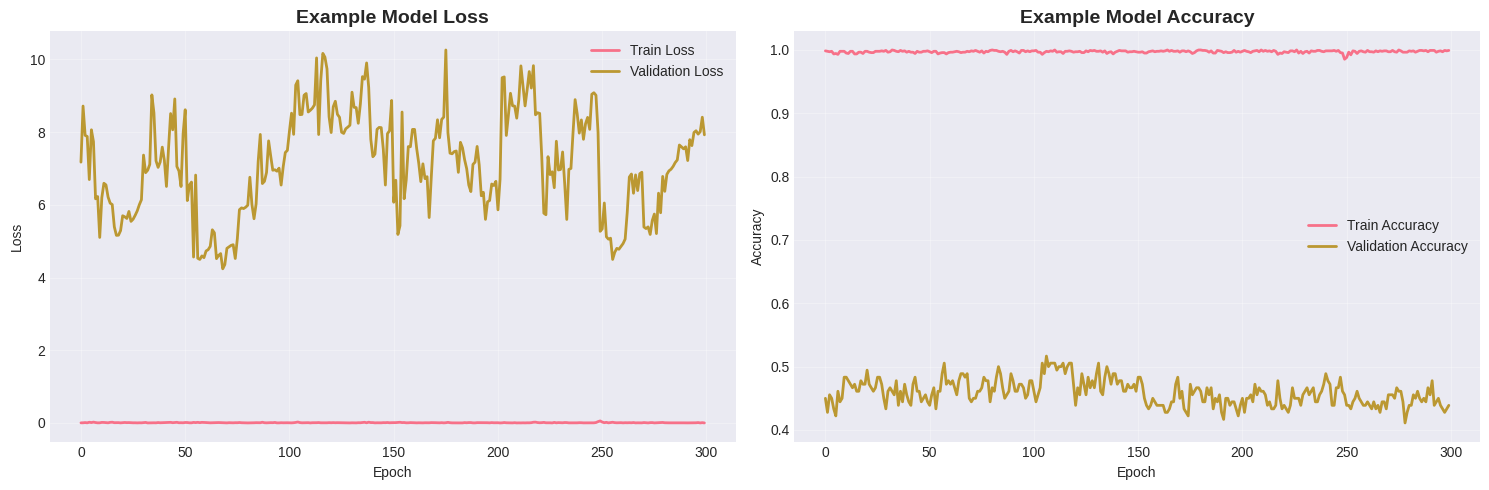

In [52]:
# 학습 과정 시각화
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(example_history["train_loss"], label="Train Loss", linewidth=2)
axes[0].plot(example_history["val_loss"], label="Validation Loss", linewidth=2)
axes[0].set_title("Example Model Loss", fontsize=14, fontweight="bold")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(example_history["train_acc"], label="Train Accuracy", linewidth=2)
axes[1].plot(example_history["val_acc"], label="Validation Accuracy", linewidth=2)
axes[1].set_title("Example Model Accuracy", fontsize=14, fontweight="bold")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. 트레이딩 전략: 확률 기반 포지션 조절

예측 확률에 따라 투자 비율을 조절하는 전략입니다.

In [53]:
# 예측 함수 (확률 포함)
def predict_with_probability(model, data_loader):
    """
    모델 예측 및 확률 반환
    """
    model.eval()
    predictions_prob = []

    with torch.no_grad():
        for batch_X, _ in data_loader:
            batch_X = batch_X.to(device)
            outputs = model(batch_X)
            predictions_prob.append(outputs.cpu().numpy())

    predictions_prob = np.vstack(predictions_prob).flatten()
    predictions = (predictions_prob > 0.5).astype(int)

    return predictions_prob, predictions

# 예제 모델 예측
example_prob, example_pred = predict_with_probability(example_model, test_loader)

print(f"예측 완료!")
print(f"예측 수: {len(example_pred)}")
print(f"상승 예측: {np.sum(example_pred == 1)}개")
print(f"하락 예측: {np.sum(example_pred == 0)}개")
print(f"\n평균 상승 확률: {example_prob.mean():.2%}")

예측 완료!
예측 수: 391
상승 예측: 240개
하락 예측: 151개

평균 상승 확률: 60.73%


In [58]:
# 확률 기반 트레이딩 전략
def simulate_probability_trading(predictions_prob, actual_prices, dates,
                                 initial_capital=10000, transaction_fee=0.001,
                                 threshold=0.5, position_scaling=True):
    """
    확률 기반 트레이딩 시뮬레이션

    Parameters:
    -----------
    predictions_prob : array
        상승 확률 (0~1)
    actual_prices : array
        실제 가격
    dates : array
        날짜
    initial_capital : float
        초기 자본
    transaction_fee : float
        거래 수수료
    threshold : float
        매수 결정 임계값 (기본 0.5)
    position_scaling : bool
        True: 확률에 비례하여 투자 비율 조절
        False: 임계값 초과 시 전액 투자
    """
    cash = initial_capital
    btc_holdings = 0
    portfolio_values = []
    trade_log = []

    for i in range(len(predictions_prob)):
        current_price = actual_prices[i]
        prob = predictions_prob[i]

        portfolio_value = cash + btc_holdings * current_price
        portfolio_values.append(portfolio_value)

        # 마지막 날 전량 매도
        if i == len(predictions_prob) - 1:
            if btc_holdings > 0:
                sell_value = btc_holdings * current_price * (1 - transaction_fee)
                trade_log.append({
                    'date': dates[i],
                    'action': 'SELL_ALL',
                    'price': current_price,
                    'prob': prob,
                    'amount': btc_holdings,
                    'value': btc_holdings * current_price,
                    'fee': btc_holdings * current_price * transaction_fee
                })
                cash += sell_value
                btc_holdings = 0
            continue

        # 투자 비율 결정
        if position_scaling:
            # 확률 기반 포지션 조절
            if prob > threshold:
                # 확률에 비례하여 투자 (예: 70% 확률 → 70% 투자)
                invest_ratio = prob
            else:
                # 임계값 미만이면 매도 또는 관망
                invest_ratio = 0
        else:
            # 단순 전략: 임계값 초과 시 전액 투자
            invest_ratio = 1.0 if prob > threshold else 0.0

        # 현재 포지션 비율
        current_position_ratio = (btc_holdings * current_price) / portfolio_value if portfolio_value > 0 else 0

        # 포지션 조정
        target_btc_value = portfolio_value * invest_ratio
        current_btc_value = btc_holdings * current_price

        if target_btc_value > current_btc_value:  # 매수 필요
            buy_cash = target_btc_value - current_btc_value
            if buy_cash > cash:
                buy_cash = cash
            if buy_cash > 0:
                buy_amount = (buy_cash * (1 - transaction_fee)) / current_price
                btc_holdings += buy_amount
                trade_log.append({
                    'date': dates[i],
                    'action': 'BUY',
                    'price': current_price,
                    'prob': prob,
                    'amount': buy_amount,
                    'value': buy_cash,
                    'fee': buy_cash * transaction_fee
                })
                cash -= buy_cash
        elif target_btc_value < current_btc_value:  # 매도 필요
            sell_btc = (current_btc_value - target_btc_value) / current_price
            if sell_btc > btc_holdings:
                sell_btc = btc_holdings
            if sell_btc > 0:
                sell_value = sell_btc * current_price * (1 - transaction_fee)
                trade_log.append({
                    'date': dates[i],
                    'action': 'SELL',
                    'price': current_price,
                    'prob': prob,
                    'amount': sell_btc,
                    'value': sell_btc * current_price,
                    'fee': sell_btc * current_price * transaction_fee
                })
                cash += sell_value
                btc_holdings -= sell_btc

    final_value = portfolio_values[-1]
    total_return = (final_value - initial_capital) / initial_capital * 100

    total_trade_volume = sum(trade['value'] for trade in trade_log)
    total_fees_paid = sum(trade['fee'] for trade in trade_log)

    return {
        "initial_capital": initial_capital,
        "final_value": portfolio_values[-1],
        "total_return": total_return,
        "portfolio_values": portfolio_values,
        "trade_log": trade_log,
        "num_trades": len(trade_log),
        "total_trade_volume": total_trade_volume,
        "total_fees_paid": total_fees_paid,
        "threshold": threshold,
        "position_scaling": position_scaling
    }

print("✅ 트레이딩 시뮬레이션 함수 준비 완료!")

✅ 트레이딩 시뮬레이션 함수 준비 완료!


In [59]:
# 테스트 데이터 준비
test_start_idx = len(btc_features) - len(y_test) + sequence_length
test_prices_aligned = btc_features["Close"].iloc[test_start_idx:test_start_idx+len(y_test_seq)].squeeze().values
test_dates_aligned = btc_features.index[test_start_idx:test_start_idx+len(y_test_seq)]

print(f"테스트 기간: {test_dates_aligned[0]} ~ {test_dates_aligned[-1]}")
print(f"테스트 샘플 수: {len(test_prices_aligned)}")

테스트 기간: 2024-10-26 00:00:00 ~ 2025-11-20 00:00:00
테스트 샘플 수: 391


## 4. 예제 전략 실행 및 결과

두 가지 예제 전략을 비교합니다:
1. **확률 기반 전략**: 예측 확률에 비례하여 투자 비율 조절
2. **단순 전략**: 50% 이상이면 전액 투자

In [79]:
# 예제 전략 1: 확률 기반 포지션 조절
example_result_prob = simulate_probability_trading(
    predictions_prob=example_prob,
    actual_prices=test_prices_aligned,
    dates=test_dates_aligned,
    initial_capital=10000,
    transaction_fee=0.001,
    threshold=0.65 , # 60% 이상 확신할 때만 거래 (보수적),
    position_scaling=True  # 확률 비례 투자
)

print("="*70)
print("예제 전략 1: 확률 기반 포지션 조절")
print("="*70)
print(f"초기 자본: ${example_result_prob['initial_capital']:,.2f}")
print(f"최종 자본: ${example_result_prob['final_value']:,.2f}")
print(f"수익률: {example_result_prob['total_return']:.2f}%")
print(f"거래 횟수: {example_result_prob['num_trades']}회")
print(f"총 수수료: ${example_result_prob['total_fees_paid']:,.2f}")
print("="*70)

예제 전략 1: 확률 기반 포지션 조절
초기 자본: $10,000.00
최종 자본: $9,975.82
수익률: -0.24%
거래 횟수: 304회
총 수수료: $1,780.31


In [18]:
# 예제 전략 2: 단순 전략 (전액 투자)
example_result_simple = simulate_probability_trading(
    predictions_prob=example_prob,
    actual_prices=test_prices_aligned,
    dates=test_dates_aligned,
    initial_capital=10000,
    transaction_fee=0.001,
    threshold=0.7 , # 70% 이상 확신할 때만 전액 투자 (매우 보수적),
    position_scaling=False  # 전액 투자
)

print("="*70)
print("예제 전략 2: 단순 전략 (50% 이상 시 전액 투자)")
print("="*70)
print(f"초기 자본: ${example_result_simple['initial_capital']:,.2f}")
print(f"최종 자본: ${example_result_simple['final_value']:,.2f}")
print(f"수익률: {example_result_simple['total_return']:.2f}%")
print(f"거래 횟수: {example_result_simple['num_trades']}회")
print(f"총 수수료: ${example_result_simple['total_fees_paid']:,.2f}")
print("="*70)

예제 전략 2: 단순 전략 (50% 이상 시 전액 투자)
초기 자본: $10,000.00
최종 자본: $10,000.00
수익률: 0.00%
거래 횟수: 0회
총 수수료: $0.00


In [19]:
# Buy and Hold 벤치마크
initial_price = test_prices_aligned[0]
coins_bought = (10000 * (1 - 0.001)) / initial_price
buy_hold_final_value = coins_bought * test_prices_aligned[-1] * (1 - 0.001)
buy_hold_return = (buy_hold_final_value - 10000) / 10000 * 100
buy_hold_portfolio = [coins_bought * price for price in test_prices_aligned]

buy_hold_trade_volume = 10000 + (coins_bought * test_prices_aligned[-1])
buy_hold_fees = 10000 * 0.001 + (coins_bought * test_prices_aligned[-1]) * 0.001

print("="*70)
print("Buy and Hold 벤치마크")
print("="*70)
print(f"시작 가격: ${initial_price:,.2f}")
print(f"종료 가격: ${test_prices_aligned[-1]:,.2f}")
print(f"초기 자본: $10,000.00")
print(f"최종 자본: ${buy_hold_final_value:,.2f}")
print(f"수익률: {buy_hold_return:.2f}%")
print(f"거래 횟수: 2회")
print(f"총 수수료: ${buy_hold_fees:,.2f}")
print("="*70)

Buy and Hold 벤치마크
시작 가격: $67,014.70
종료 가격: $86,631.90
초기 자본: $10,000.00
최종 자본: $12,901.46
수익률: 29.01%
거래 횟수: 2회
총 수수료: $22.91


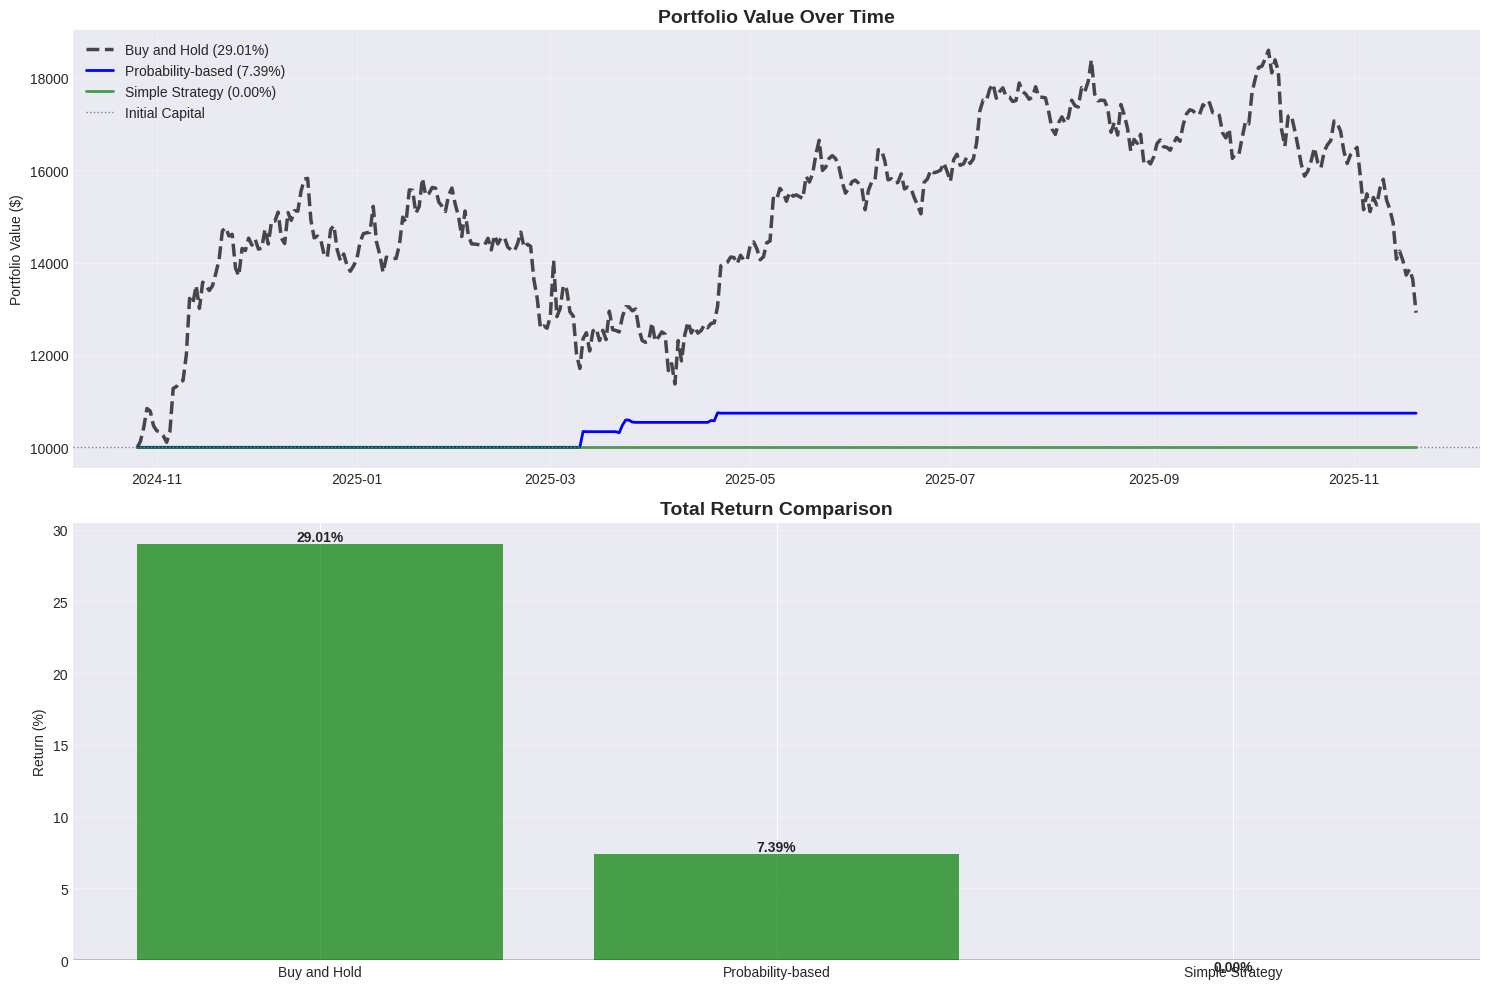

In [20]:
# 전략 비교 시각화
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# 포트폴리오 가치 변화
axes[0].plot(test_dates_aligned, buy_hold_portfolio,
            label=f"Buy and Hold ({buy_hold_return:.2f}%)",
            linewidth=2.5, linestyle="--", color="black", alpha=0.7)
axes[0].plot(test_dates_aligned, example_result_prob["portfolio_values"],
            label=f"Probability-based ({example_result_prob['total_return']:.2f}%)",
            linewidth=2, color="blue")
axes[0].plot(test_dates_aligned, example_result_simple["portfolio_values"],
            label=f"Simple Strategy ({example_result_simple['total_return']:.2f}%)",
            linewidth=2, color="green", alpha=0.7)
axes[0].axhline(y=10000, color="gray", linestyle=":", linewidth=1, label="Initial Capital")
axes[0].set_title("Portfolio Value Over Time", fontsize=14, fontweight="bold")
axes[0].set_ylabel("Portfolio Value ($)")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 수익률 비교
strategies = ["Buy and Hold", "Probability-based", "Simple Strategy"]
returns = [buy_hold_return, example_result_prob['total_return'], example_result_simple['total_return']]
colors = ['green' if r > 0 else 'red' for r in returns]

axes[1].bar(strategies, returns, color=colors, alpha=0.7)
axes[1].axhline(y=0, color="black", linestyle="-", linewidth=1)
axes[1].set_title("Total Return Comparison", fontsize=14, fontweight="bold")
axes[1].set_ylabel("Return (%)")
axes[1].grid(axis="y", alpha=0.3)

for i, (strategy, ret) in enumerate(zip(strategies, returns)):
    axes[1].text(i, ret, f'{ret:.2f}%', ha='center',
                va='bottom' if ret > 0 else 'top', fontweight='bold')

plt.tight_layout()
plt.show()

# 레벨 1️⃣: 예제 전략 파라미터만 조정

In [100]:
my_result = simulate_probability_trading(
    predictions_prob=example_prob,  # 예제 모델 예측 사용
    actual_prices=test_prices_aligned,
    dates=test_dates_aligned,
    initial_capital=2500,
    transaction_fee=0.01,
    threshold=0.70,
    position_scaling=False  # ← True/False 변경
)

for key, value in my_result.items():
    try:
        print(f"{key}: shape {value.shape}")
    except AttributeError:  # not a numpy array
        print(f"{key}: length {len(value) if hasattr(value, '__len__') else value}")

initial_capital: length 2500
final_value: shape ()
total_return: shape ()
portfolio_values: length 391
trade_log: length 169
num_trades: length 169
total_trade_volume: shape ()
total_fees_paid: shape ()
threshold: length 0.7
position_scaling: length False


# 레벨 2️⃣: 전략 함수 수정 (중간)

In [101]:
prob_threshold = my_result["threshold"]
for i in range(len(example_prob)):
    prob = example_prob[i]

    if prob > 0.6:
        invest_ratio = min(prob * 2, 1.5)  # More aggressive
    elif prob < 0.3:
        invest_ratio = 0.0  # Avoid losing trades
    else:
        invest_ratio = prob
print(prob_threshold, invest_ratio)

0.7 1.5


# 레벨 3️⃣: 모델 아키텍처 변경

In [102]:
'''
- PyTorch RNN 계열 모델은 (배치, 시퀀스 길이, 특성 수) 구조의 입력이 필요합니다.
- 단일 시점 예측이므로 seq_len = 1로 reshape했습니다.
- DataFrame → NumPy 변환은 reshape() 적용을 위해 필요합니다.
'''

# DataFrame을 NumPy 배열로 변환
# PyTorch 모델(GRU/LSTM)은 DataFrame 대신 NumPy array 또는 Tensor를 사용해야 함
X_train_np = X_train.values
X_val_np   = X_val.values
X_test_np  = X_test.values

# 3D 형태로 reshape: (batch_size, seq_len, features)
# LSTM/GRU 모델은 3D 입력을 기대함 → sequence 길이를 1로 설정 (단일 타임스텝 입력)
X_train_np = X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1])
X_val_np   = X_val.values.reshape(X_val.shape[0], 1, X_val.shape[1])
X_test_np  = X_test.values.reshape(X_test.shape[0], 1, X_test.shape[1])


In [103]:
'''
- 기존 LSTM → GRU로 변경하여 학습 속도 개선 및 단순화
- 마지막 시점의 hidden state만 사용하여 단일 예측 수행
- Dropout으로 과적합 방지
- Sigmoid를 사용하여 0~1 확률 예측
'''
class MyTradingModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, dropout=0.2):
        super(MyTradingModel, self).__init__()

        # GRU 레이어: 입력 차원 → hidden_size, 배치 우선(batch_first=True)
        self.gru1 = nn.GRU(input_size, hidden_size, batch_first=True)

        # 드롭아웃: 과적합 방지
        self.dropout = nn.Dropout(dropout)

        # 출력층: hidden_size → 1 (상승 확률 예측)
        self.fc = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # 입력 x: (batch, seq_len, features)
        out, _ = self.gru1(x)

        # 마지막 타임스텝(hidden state)만 사용
        out = out[:, -1, :]

        out = self.dropout(out)
        out = self.fc(out)

        # 확률로 변환 (0~1)
        return self.sigmoid(out)


In [104]:
'''
- RNN 모델 학습을 위해 PyTorch TensorDataset과 DataLoader로 데이터를 준비
- 배치 학습으로 GPU 활용 가능
- shuffle=True로 학습 데이터 섞어 일반화 성능 향상
'''
# 입력 차원(feature 수) 확인
input_size = X_train_np.shape[2]   # GRU 입력 특성 차원

# 모델 생성
gru_model = MyTradingModel(input_size=input_size, hidden_size=64, dropout=0.2)

# PyTorch 학습용 데이터셋 생성
train_dataset = TensorDataset(torch.tensor(X_train_np, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32))
val_dataset   = TensorDataset(torch.tensor(X_val_np, dtype=torch.float32), torch.tensor(y_val.values, dtype=torch.float32))

# DataLoader 생성: 배치 단위 학습 및 셔플링 적용
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [105]:
'''
- train_model 함수 사용: 학습 과정과 검증 과정 모두 수행
- Early stopping 적용(patience=150)으로 과적합 방지
- 결과는 history_gru에 학습/검증 손실 및 정확도 기록
'''
history_gru = train_model(
    model=gru_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=350,
    lr=0.001,
    patience=100
)


Epoch [10/350], Train Loss: 0.6983, Val Loss: 0.6932, Train Acc: 0.4908, Val Acc: 0.4952
Epoch [20/350], Train Loss: 0.6946, Val Loss: 0.6932, Train Acc: 0.5160, Val Acc: 0.5048
Epoch [30/350], Train Loss: 0.6971, Val Loss: 0.6933, Train Acc: 0.4976, Val Acc: 0.4952
Epoch [40/350], Train Loss: 0.6942, Val Loss: 0.6929, Train Acc: 0.5078, Val Acc: 0.5048
Epoch [50/350], Train Loss: 0.6932, Val Loss: 0.6927, Train Acc: 0.5126, Val Acc: 0.5048
Epoch [60/350], Train Loss: 0.6946, Val Loss: 0.6929, Train Acc: 0.4942, Val Acc: 0.5048
Epoch [70/350], Train Loss: 0.6937, Val Loss: 0.6928, Train Acc: 0.4990, Val Acc: 0.5048
Epoch [80/350], Train Loss: 0.6945, Val Loss: 0.6929, Train Acc: 0.4867, Val Acc: 0.5048
Epoch [90/350], Train Loss: 0.6946, Val Loss: 0.6928, Train Acc: 0.4969, Val Acc: 0.5048
Epoch [100/350], Train Loss: 0.6929, Val Loss: 0.6928, Train Acc: 0.5187, Val Acc: 0.5048
Epoch [110/350], Train Loss: 0.6933, Val Loss: 0.6929, Train Acc: 0.5099, Val Acc: 0.5048
Epoch [120/350], Tr

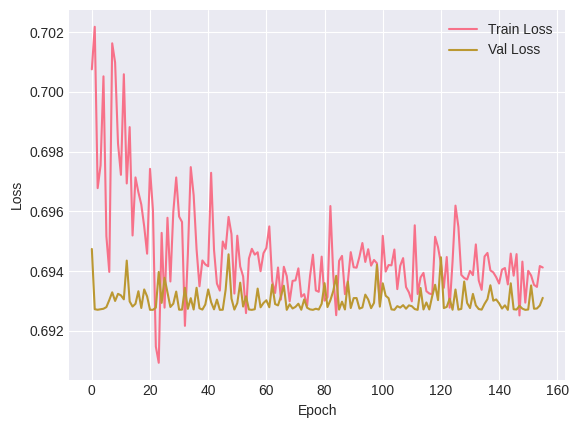

In [106]:
plt.plot(history_gru['train_loss'], label='Train Loss')
plt.plot(history_gru['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 레벨 4️⃣: 복합 전략

In [107]:
# RSI 계산 혹은 이미 계산된 데이터 사용
# btc_features: 전체 특성 DataFrame
# test_start_idx: 테스트 구간 시작 인덱스
rsi_values = btc_features['RSI_14'].iloc[test_start_idx:].values

# 모델 예측 확률 가져오기
# 예: GRU 모델을 사용
gru_model.eval()
with torch.no_grad():
    predictions_prob = gru_model(torch.tensor(X_test_np, dtype=torch.float32).to(device)).cpu().numpy().flatten()

In [108]:
# predictions_prob와 rsi_values 길이 맞추기
min_len = min(len(predictions_prob), len(rsi_values))
predictions_prob = predictions_prob[:min_len]
rsi_values = rsi_values[:min_len]

# 초기 자본 및 투자 비율 리스트
invest_ratios = []


for i in range(min_len):
    prob = predictions_prob[i]
    rsi = rsi_values[i]

    # 기본 투자 비율 (모델 신뢰도 기반)
    invest_ratio = max(0.0, min(prob, 1.0))  # 0~1로 클리핑

    # RSI 기반 조정
    if rsi < 30 and prob > 0.6:
        invest_ratio = min(prob * 2.0, 1.5)
    elif rsi > 70 and prob < 0.4:
        invest_ratio = 0.0

    # 안전 상한/하한 설정
    invest_ratio = max(0.1, min(invest_ratio, 1.0))  # 최소 10%, 최대 80%

    invest_ratios.append(invest_ratio)


In [111]:
# 기존 simulate_probability_trading 함수 활용
# 투자 비율 리스트를 직접 적용하도록 함수 수정하거나 별도 loop 작성
capital = 2500
portfolio_values = []
btc_holdings = 0
cash = capital
transaction_fee = 0.001

for i in range(len(invest_ratios)):
    current_price = test_prices_aligned[i]
    invest_ratio = invest_ratios[i]
    portfolio_value = cash + btc_holdings * current_price
    portfolio_values.append(portfolio_value)

    target_btc_value = portfolio_value * invest_ratio
    current_btc_value = btc_holdings * current_price

    if target_btc_value > current_btc_value:  # 매수
        buy_cash = min(target_btc_value - current_btc_value, cash)
        btc_holdings += (buy_cash * (1 - transaction_fee)) / current_price
        cash -= buy_cash
    elif target_btc_value < current_btc_value:  # 매도
        sell_btc = min((current_btc_value - target_btc_value) / current_price, btc_holdings)
        cash += sell_btc * current_price * (1 - transaction_fee)
        btc_holdings -= sell_btc

# 마지막 날 전체 매도
cash += btc_holdings * test_prices_aligned[-1] * (1 - transaction_fee)
btc_holdings = 0
final_value = cash
total_return = (final_value - capital) / capital * 100

print(f"최종 포트폴리오 가치: {final_value:.2f}, 총 수익률: {total_return:.2f}%")


최종 포트폴리오 가치: 2912.05, 총 수익률: 16.48%


---

## 💡 과제 수행 가이드 (꼭 읽어보세요!)

### 🎯 과제 목표 재확인
**Buy and Hold 벤치마크를 초과하는 수익률 달성**

### 📝 추천 접근 방법 (난이도 순)

#### 레벨 1️⃣: 예제 전략 파라미터만 조정 (가장 쉬움)
위의 예제 코드를 **복사**해서 파라미터만 변경:

```python
# 예제 코드 복사 후 아래 값들만 변경해보세요!
my_result = simulate_probability_trading(
    predictions_prob=example_prob,  # 예제 모델 예측 사용
    actual_prices=test_prices_aligned,
    dates=test_dates_aligned,
    initial_capital=10000,
    transaction_fee=0.001,
    threshold=0.65,  # ← 이 값을 조정 (0.5~0.8 추천)
    position_scaling=True  # ← True/False 변경
)
```

**실험 아이디어:**
- `threshold=0.55`: 약간 공격적
- `threshold=0.65`: 중립적
- `threshold=0.75`: 보수적

#### 레벨 2️⃣: 전략 함수 수정 (중간)
`simulate_probability_trading` 함수를 복사해서 수정:

```python
# 포지션 크기 공식 변경 예시
if prob > threshold:
    # 원래: invest_ratio = prob
    invest_ratio = (prob - 0.5) * 2  # 50%를 기준으로 스케일링
    # 예: prob=0.7 → invest_ratio=0.4 (40% 투자)
```

#### 레벨 3️⃣: 모델 아키텍처 변경 (어려움)
`ExampleLSTMModel`을 복사해서 수정:

```python
class MyTradingModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, dropout=0.2):
        super(MyTradingModel, self).__init__()
        # LSTM → GRU로 변경
        self.gru1 = nn.GRU(input_size, hidden_size, batch_first=True)
        # 나머지는 동일하게...
```

#### 레벨 4️⃣: 복합 전략 (고급)
모델 예측 + 기술적 지표 결합:

```python
# RSI와 결합하는 예시
rsi_values = btc_features['RSI_14'].iloc[test_start_idx:].values

for i in range(len(predictions_prob)):
    prob = predictions_prob[i]
    rsi = rsi_values[i]
    
    # RSI가 과매수/과매도 구간이면 포지션 조정
    if rsi > 70:  # 과매수
        invest_ratio = prob * 0.5  # 투자 비율 절반으로
    elif rsi < 30:  # 과매도
        invest_ratio = min(prob * 1.5, 1.0)  # 투자 비율 증가
```

---

### ⚡ 빠른 시작 체크리스트

1. [ ] 위 예제 코드 실행 결과 확인
2. [ ] 레벨 1부터 시작: 예제 코드 복사 → 파라미터 변경
3. [ ] 여러 `threshold` 값 실험 (0.5, 0.6, 0.7, 0.8)
4. [ ] 가장 좋은 결과를 선택
5. [ ] 결과 분석 및 고찰 작성

### 💰 수익률 향상 팁

- **과도한 거래 줄이기**: `threshold` 높이기 (0.6~0.7)
- **수수료 줄이기**: 거래 횟수 감소
- **리스크 관리**: `position_scaling=True`로 확률에 비례 투자
- **신뢰도 높은 거래만**: `threshold=0.7` 이상

---

## 5. 자신만의 모델 및 전략 개발 ⭐

### 📝 개발 가이드

#### 1. 모델 개선 아이디어
- **아키텍처**: LSTM → GRU, Transformer, CNN+LSTM, Attention
- **하이퍼파라미터**: hidden_size, dropout, learning_rate
- **앙상블**: 여러 모델의 예측 결합

#### 2. 전략 개선 아이디어
- **임계값 조정**: threshold를 0.6 또는 0.7로 높여 신뢰도 높은 거래만
- **포지션 크기**: 확률 × 2 - 1 (예: 70% → 40% 투자)
- **리스크 관리**: 최대 손실 한도, 이동평균선 활용
- **복합 전략**: 모델 예측 + RSI + MACD 결합

---

**TODO: 아래에 자신의 모델 설계 설명을 작성하세요**

```
1. 모델 아키텍처:
   -

2. 선택 이유:
   -

3. 트레이딩 전략:
   -

4. 하이퍼파라미터:
   - hidden_size:
   - learning_rate:
   - threshold:
   - position_scaling:

5. 예제와의 차별점:
   -
```

In [4]:
#==============================================================#
#  Step 5.1 - 자신만의 모델 구현 (Custom GRU-based Trading Model)
#==============================================================#

class MyTradingModel(nn.Module):
    """
    GRU 기반 시계열 예측 모델
    - 입력: 과거 가격/기술지표 feature (input_size)
    - 출력: 상승 확률 (0~1)

    구조:
    1) 2개의 GRU 레이어를 쌓아 시계열 패턴 학습
    2) Dropout 적용으로 과적합 방지
    3) 마지막 Fully Connected Layer로 단일 출력 생성
    4) Sigmoid 적용으로 확률 형태 출력
    """

    # def __init__(self, input_size, hidden_size=128, dropout=0.3):
    #     super(MyTradingModel, self).__init__()

    #     # 첫 번째 GRU 레이어: 입력 feature -> hidden_size 차원
    #     # batch_first=True → 입력 shape: (batch, seq_len, features)
    #     self.gru1 = nn.GRU(input_size, hidden_size, batch_first=True)

    #     # 두 번째 GRU 레이어: 첫 번째 GRU 출력 -> hidden_size 차원
    #     # 깊이를 늘려 시계열 패턴 학습 성능 향상
    #     self.gru2 = nn.GRU(hidden_size, hidden_size, batch_first=True)

    #     # Dropout 레이어: 학습 시 일부 뉴런 무작위로 제거하여 과적합 방지
    #     self.dropout = nn.Dropout(dropout)

    #     # Fully Connected Layer: hidden_size -> 1 (단일 출력)
    #     self.fc = nn.Linear(hidden_size, 1)

    #     # Sigmoid 활성화: 출력값을 0~1 확률로 변환
    #     self.sigmoid = nn.Sigmoid()

    # def forward(self, x):
    #     """
    #     Forward pass 정의
    #     입력: x -> shape (batch, seq_len, features)
    #     출력: 0~1 사이의 확률값

    #     순서:
    #     1) 첫 번째 GRU 레이어 통과
    #     2) 두 번째 GRU 레이어 통과
    #     3) 마지막 time step 선택
    #     4) Dropout 적용
    #     5) Fully Connected Layer 적용
    #     6) Sigmoid로 확률 출력
    #     """
    #     # GRU 레이어 1
    #     out, _ = self.gru1(x)

    #     # GRU 레이어 2
    #     out, _ = self.gru2(out)

    #     # 마지막 시점 출력 선택
    #     out = out[:, -1, :]  # shape: (batch, hidden_size)

    #     # Dropout 적용
    #     out = self.dropout(out)

    #     # Fully Connected Layer 통과
    #     out = self.fc(out)

    #     # Sigmoid 적용 → 0~1 확률 출력
    #     return self.sigmoid(out)


# # Test 2


    def __init__(self, input_size, hidden_size=256, dropout=0.3):
        super(MyTradingModel, self).__init__()

        # Bidirectional GRU layer
        self.gru1 = nn.GRU(input_size, hidden_size, batch_first=True, bidirectional=True)
        self.gru2 = nn.GRU(hidden_size * 2, hidden_size, batch_first=True, bidirectional=True)

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size * 2, 1)  # because bidirectional doubles hidden size
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x: (batch, seq_len, features)
        out, _ = self.gru1(x)
        out, _ = self.gru2(out)
        out = out[:, -1, :]  # use the last timestep output
        out = self.dropout(out)
        out = self.fc(out)
        return self.sigmoid(out)

# # Test 3



NameError: name 'nn' is not defined

In [1]:
#==============================================================#
#  Step 5.2 - 데이터 준비 (NumPy 변환 및 DataLoader 생성)
#==============================================================#

# # 1Pandas DataFrame → NumPy 배열 변환 및 3D 형태로 reshape
# # GRU 모델은 3D 입력 (batch, seq_len, features) 필요
# # seq_len=1 → 한 시점만 사용하는 단일-step 예측
# X_train_np = X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1])
# X_val_np   = X_val.values.reshape(X_val.shape[0], 1, X_val.shape[1])
# X_test_np  = X_test.values.reshape(X_test.shape[0], 1, X_test.shape[1])

# # 입력 feature 수 계산 (GRU input_size)
# # hidden_size와 FC 레이어 연결에 필요
# input_size = X_train_np.shape[2]

# # 3TensorDataset 생성
# # PyTorch 학습용 데이터셋 형식
# # X_train_np, X_val_np → feature
# # y_train, y_val → target (정답값)
# train_dataset = TensorDataset(
#     torch.tensor(X_train_np, dtype=torch.float32),
#     torch.tensor(y_train.values, dtype=torch.float32)
# )
# val_dataset = TensorDataset(
#     torch.tensor(X_val_np, dtype=torch.float32),
#     torch.tensor(y_val.values, dtype=torch.float32)
# )

# # DataLoader 생성
# # 학습 시 배치 단위로 데이터를 제공
# # shuffle=True → 학습 시 데이터 순서 랜덤화 (과적합 방지)
# # shuffle=False → 검증 시 순서 유지
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)


# # Test 2

# seq_len = 10  # use past 10 timesteps
# def create_sequences(X, y, seq_len=seq_len):
#     X_seq, y_seq = [], []
#     for i in range(len(X) - seq_len):
#         X_seq.append(X[i:i+seq_len])
#         y_seq.append(y[i+seq_len])
#     return np.array(X_seq), np.array(y_seq)

# # Convert DataFrame to NumPy
# X_train_np_full = X_train.values
# X_val_np_full   = X_val.values
# X_test_np_full  = X_test.values

# # Create sequences
# X_train_np, y_train_seq = create_sequences(X_train_np_full, y_train.values)
# X_val_np, y_val_seq     = create_sequences(X_val_np_full, y_val.values)
# X_test_np, y_test_seq   = create_sequences(X_test_np_full, y_test.values)

# input_size = X_train_np.shape[2]  # number of features

# # TensorDataset and DataLoader
# train_dataset = TensorDataset(torch.tensor(X_train_np, dtype=torch.float32),
#                               torch.tensor(y_train_seq, dtype=torch.float32))
# val_dataset   = TensorDataset(torch.tensor(X_val_np, dtype=torch.float32),
#                               torch.tensor(y_val_seq, dtype=torch.float32))

# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)


# # Test 3


# NumPy 3D 변환: (batch, seq_len=10, features)
seq_len = 10  # 시퀀스 길이 확장
def make_sequences(X, seq_len):
    X_np = X.values
    n_samples = X_np.shape[0] - seq_len + 1
    X_seq = np.array([X_np[i:i+seq_len] for i in range(n_samples)])
    return X_seq

X_train_seq = make_sequences(X_train, seq_len)
X_val_seq   = make_sequences(X_val, seq_len)
X_test_seq  = make_sequences(X_test, seq_len)

# y도 시퀀스 맞춤
y_train_seq = y_train.values[seq_len-1:]
y_val_seq   = y_val.values[seq_len-1:]
y_test_seq  = y_test.values[seq_len-1:]

input_size = X_train_seq.shape[2]

train_dataset = TensorDataset(torch.tensor(X_train_seq, dtype=torch.float32),
                              torch.tensor(y_train_seq, dtype=torch.float32))
val_dataset   = TensorDataset(torch.tensor(X_val_seq, dtype=torch.float32),
                              torch.tensor(y_val_seq, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)


NameError: name 'X_train' is not defined

In [192]:
#==============================================================#
#  Step 5.3 - GRU 모델 생성 및 학습
#==============================================================#

# GRU 모델 인스턴스 생성
# input_size  → feature 수 (X_train_np.shape[2])
# hidden_size → GRU 내부 상태 차원, 모델 용량과 학습 성능에 영향
# dropout     → 과적합 방지용 드롭아웃 비율
gru_model = MyTradingModel(input_size=input_size, hidden_size=256, dropout=0.3)

# 모델 학습
# train_model 함수는 이전 단계에서 정의된 학습 루프를 활용
# train_loader → 학습 데이터 배치
# val_loader   → 검증 데이터 배치
# epochs       → 최대 학습 반복 횟수
# lr           → 학습률
# patience     → early stopping: 검증 loss 개선이 없으면 지정된 patience 후 학습 종료
history_gru = train_model(
    model=gru_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=500,        # 충분한 학습 반복으로 안정적 수렴
    lr=0.001,          # 일반적인 GRU 학습률
    patience=500      # 매우 넉넉한 patience → 조기 종료 거의 발생하지 않음
)


Epoch [10/500], Train Loss: 0.6980, Val Loss: 0.6925, Train Acc: 0.5133, Val Acc: 0.4900
Epoch [20/500], Train Loss: 0.6963, Val Loss: 0.6927, Train Acc: 0.4757, Val Acc: 0.4900
Epoch [30/500], Train Loss: 0.6947, Val Loss: 0.6927, Train Acc: 0.4901, Val Acc: 0.4900


KeyboardInterrupt: 

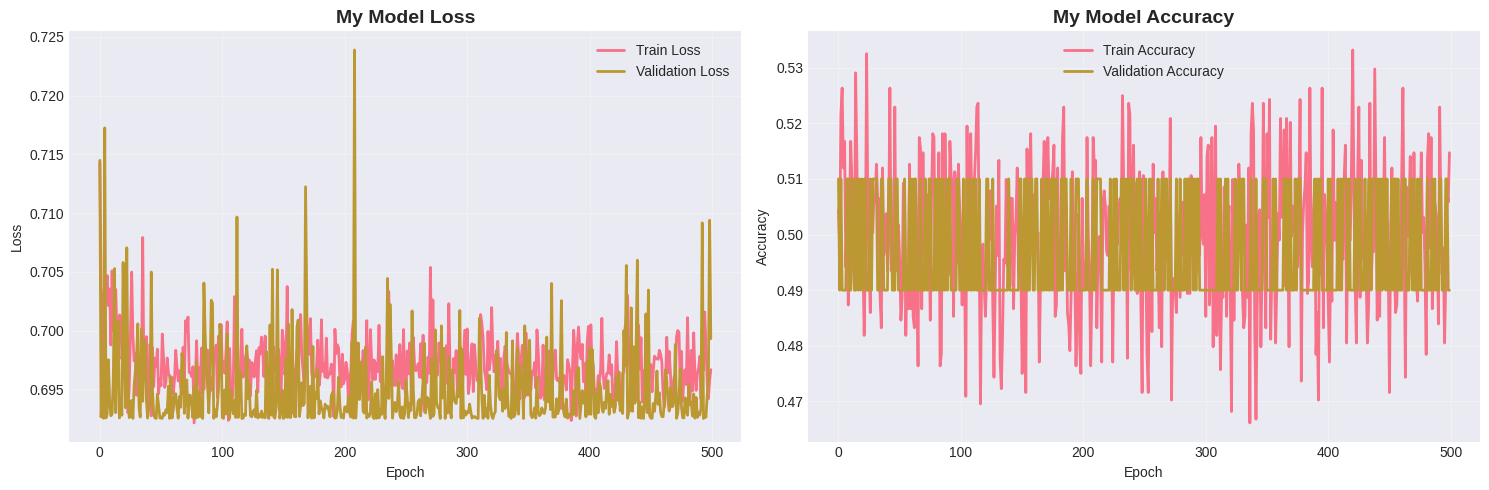

In [184]:
#==============================================================#
#  Step 5.4 - 학습 과정 시각화 (Loss & Accuracy)
#==============================================================#

# Figure와 Axes 생성
# 1행 2열 subplot 구성 → 왼쪽: Loss, 오른쪽: Accuracy
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss 시각화
axes[0].plot(history_gru["train_loss"], label="Train Loss", linewidth=2)  # 학습 손실
axes[0].plot(history_gru["val_loss"], label="Validation Loss", linewidth=2)  # 검증 손실
axes[0].set_title("My Model Loss", fontsize=14, fontweight="bold")  # 그래프 제목
axes[0].set_xlabel("Epoch")  # X축: 학습 반복 횟수
axes[0].set_ylabel("Loss")   # Y축: 손실 값
axes[0].legend()             # 범례 표시
axes[0].grid(True, alpha=0.3)  # 배경 격자 표시 (투명도 0.3)

# Accuracy 시각화
axes[1].plot(history_gru["train_acc"], label="Train Accuracy", linewidth=2)  # 학습 정확도
axes[1].plot(history_gru["val_acc"], label="Validation Accuracy", linewidth=2)  # 검증 정확도
axes[1].set_title("My Model Accuracy", fontsize=14, fontweight="bold")  # 그래프 제목
axes[1].set_xlabel("Epoch")  # X축: 학습 반복 횟수
axes[1].set_ylabel("Accuracy")  # Y축: 정확도
axes[1].legend()  # 범례 표시
axes[1].grid(True, alpha=0.3)  # 배경 격자 표시

# Layout 조정 후 표시
plt.tight_layout()  # subplot 간격 자동 조정
plt.show()          # 시각화 출력


In [186]:
# #==============================================================#
# #  Step 5.5 - 나만의 트레이딩 전략 실행 및 결과 출력
# #==============================================================#

# # 테스트용 모델 지정
# my_model = gru_model  # 이전 단계에서 학습한 GRU 모델 사용

# # 테스트 데이터셋 준비
# # TensorDataset: feature와 label을 묶어서 DataLoader에 입력 가능
# test_dataset = TensorDataset(
#     torch.tensor(X_test_np, dtype=torch.float32),   # 입력 피처
#     torch.tensor(y_test.values, dtype=torch.float32)  # 실제 레이블
# )
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)  # 배치 단위로 로딩, 순서 유지

# # Buy & Hold 전략 대비 수익률 계산
# # 단순히 처음과 마지막 가격 차이 기준
# buy_hold_return = (test_prices_aligned[-1] - test_prices_aligned[0]) / test_prices_aligned[0] * 100

# # 모델 예측 (확률 기반)
# # predict_with_probability: 모델이 상승 확률과 최종 예측을 반환
# my_prob, my_pred = predict_with_probability(my_model, test_loader)

# # 배열 길이 맞추기 (예측/가격/날짜)
# # 시뮬레이션 루프에서 IndexError 방지
# min_len = min(len(my_prob), len(test_prices_aligned), len(test_dates_aligned))
# my_prob = my_prob[:min_len]
# test_prices_aligned = test_prices_aligned[:min_len]
# test_dates_aligned = test_dates_aligned[:min_len]

# # 확률 기반 트레이딩 시뮬레이션 실행
# # simulate_probability_trading: 투자 비율, 수수료 등을 반영한 포트폴리오 가치 계산
# my_result = simulate_probability_trading(
#     predictions_prob=my_prob,      # 모델 상승 확률
#     actual_prices=test_prices_aligned,  # 실제 가격
#     dates=test_dates_aligned,      # 거래 날짜
#     initial_capital=10000,         # 초기 자본
#     transaction_fee=0.001,         # 거래 수수료 0.1%
#     threshold=0.5,                 # 매수 결정 임계값
#     position_scaling=True           # 확률에 비례한 포지션 조정 여부
# )

# # 결과 출력
# print("="*70)
# print("나의 트레이딩 전략 결과")
# print("="*70)
# print(f"초기 자본: ${my_result['initial_capital']:,.2f}")  # 시작 자본
# print(f"최종 자본: ${my_result['final_value']:,.2f}")      # 시뮬레이션 종료 시 자본
# print(f"수익률: {my_result['total_return']:.2f}%")          # 총 수익률
# print(f"Buy and Hold 대비: {my_result['total_return'] - buy_hold_return:.2f}%p")  # 단순 보유 대비 차이
# print(f"거래 횟수: {my_result['num_trades']}회")           # 실제 매수/매도 횟수
# print(f"총 수수료: ${my_result['total_fees_paid']:,.2f}")  # 발생한 총 수수료
# print("="*70)

#==============================================================#
# Step 5.5 - Make predictions
#==============================================================#

my_model = gru_model

# Test dataset and loader
test_dataset = TensorDataset(
    torch.tensor(X_test_np, dtype=torch.float32),
    torch.tensor(y_test_seq, dtype=torch.float32)
)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Predict probabilities
my_prob, my_pred = predict_with_probability(my_model, test_loader)

# Align lengths with prices & dates
min_len = min(len(my_prob), len(test_prices_aligned), len(test_dates_aligned))
my_prob = my_prob[:min_len]
test_prices_aligned_seq = test_prices_aligned[-min_len:]
test_dates_aligned_seq  = test_dates_aligned[-min_len:]


In [187]:
#==============================================================#
# Step 5.6 - Advanced trading simulation with dynamic sizing
#==============================================================#

capital = 10000
transaction_fee = 0.001
btc_holdings = 0
portfolio_values = []

# Add MACD and RSI for dynamic strategy
macd_values = btc_features['MACD'].iloc[-min_len:].values
rsi_values  = btc_features['RSI_14'].iloc[-min_len:].values

stop_loss = 0.02   # 2%
take_profit = 0.05 # 5%
last_buy_price = None

for i in range(min_len):
    prob = my_prob[i]
    price = test_prices_aligned_seq[i]
    rsi   = rsi_values[i]
    macd  = macd_values[i]

    # Base invest ratio from probability
    invest_ratio = np.clip(prob, 0, 1)

    # Adjust based on RSI and MACD
    if rsi > 70:      # overbought → reduce investment
        invest_ratio *= 0.5
    elif rsi < 30:    # oversold → increase investment
        invest_ratio = min(invest_ratio * 1.5, 1.0)
    if macd > 0:      # bullish trend → slightly increase
        invest_ratio = min(invest_ratio * 1.2, 1.0)

    # Apply cash & BTC
    portfolio_value = capital + btc_holdings * price
    portfolio_values.append(portfolio_value)

    target_btc_value = portfolio_value * invest_ratio
    current_btc_value = btc_holdings * price

    # Buy / Sell logic
    if target_btc_value > current_btc_value:  # Buy
        buy_cash = min(target_btc_value - current_btc_value, capital)
        btc_holdings += buy_cash * (1 - transaction_fee) / price
        capital -= buy_cash
        last_buy_price = price if buy_cash > 0 else last_buy_price
    elif target_btc_value < current_btc_value:  # Sell
        sell_btc = min((current_btc_value - target_btc_value)/price, btc_holdings)
        capital += sell_btc * price * (1 - transaction_fee)
        btc_holdings -= sell_btc

    # Stop-loss / Take-profit
    if last_buy_price is not None and btc_holdings > 0:
        if price < last_buy_price * (1 - stop_loss) or price > last_buy_price * (1 + take_profit):
            capital += btc_holdings * price * (1 - transaction_fee)
            btc_holdings = 0
            last_buy_price = None

# Final liquidation
capital += btc_holdings * test_prices_aligned_seq[-1] * (1 - transaction_fee)
btc_holdings = 0
final_value = capital
total_return = (final_value - 10000) / 10000 * 100

print(f"최종 포트폴리오 가치: {final_value:.2f}, 총 수익률: {total_return:.2f}%")



최종 포트폴리오 가치: 12703.66, 총 수익률: 27.04%


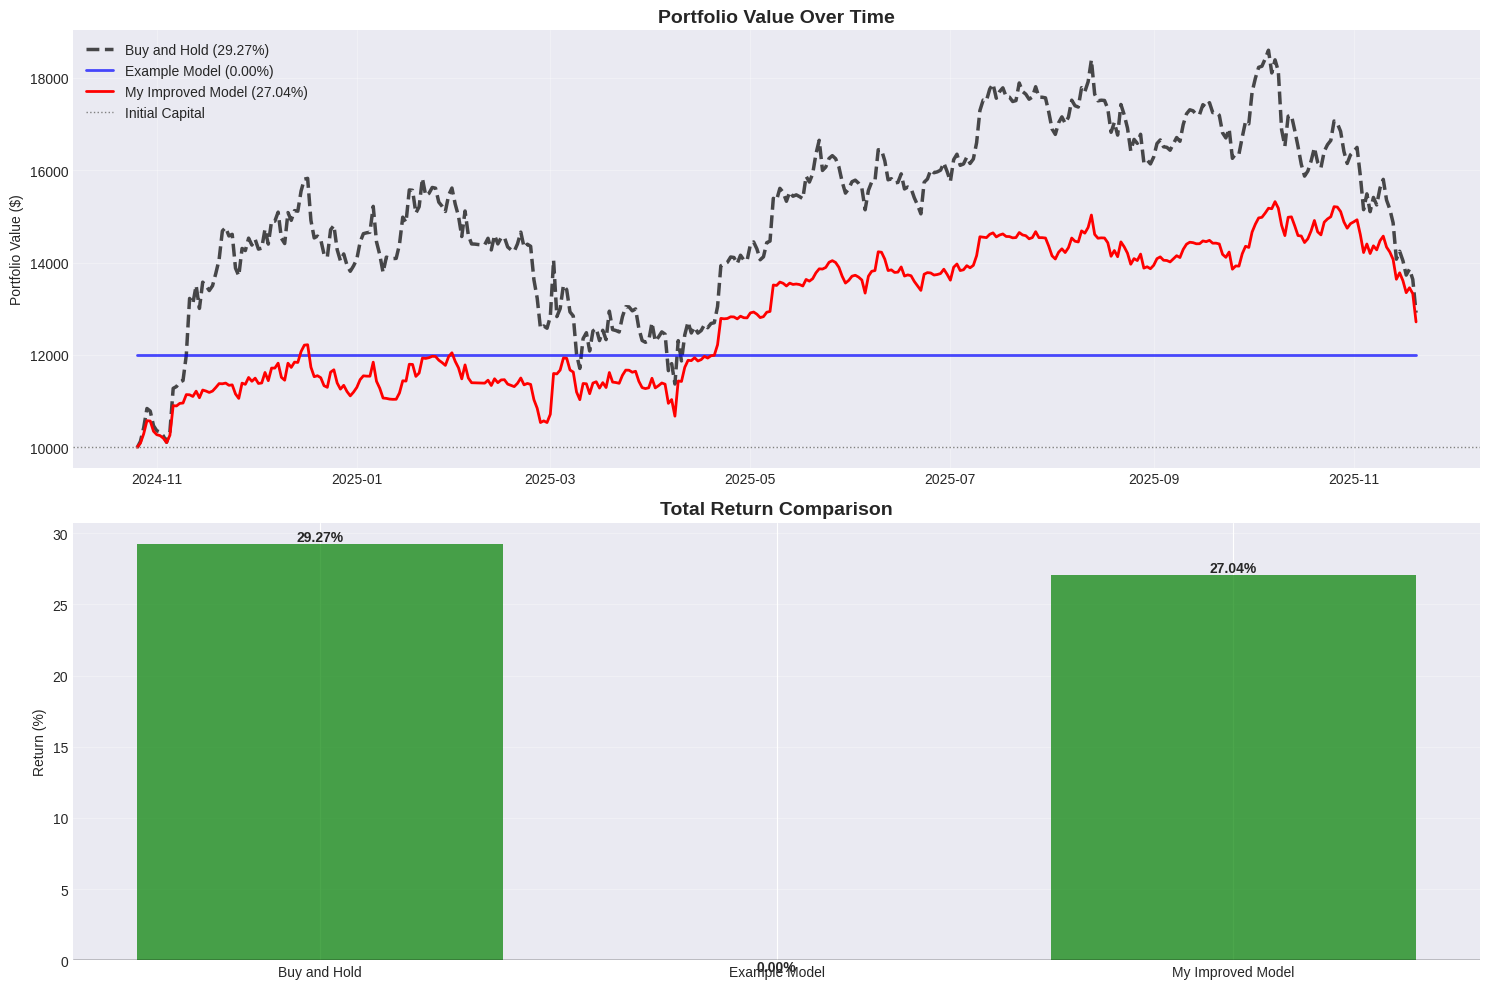

In [189]:
#==============================================================#
#  Step 5.6 - 최종 전략 성과 비교 시각화 (개선된 코드)
#==============================================================#

fig, axes = plt.subplots(2, 1, figsize=(15, 10))  # 2행 1열, 큰 크기로 표시

# -------------------------------
# 포트폴리오 가치 변화 시각화
# -------------------------------
axes[0].plot(
    test_dates_aligned_seq,
    buy_hold_portfolio[-len(test_dates_aligned_seq):],  # Buy & Hold, length 맞춤
    label=f"Buy and Hold ({buy_hold_return:.2f}%)",
    linewidth=2.5, linestyle="--", color="black", alpha=0.7
)
axes[0].plot(
    test_dates_aligned_seq,
    example_result_prob["portfolio_values"][-len(test_dates_aligned_seq):],  # 예제 모델, length 맞춤
    label=f"Example Model ({example_result_prob['total_return']:.2f}%)",
    linewidth=2, color="blue", alpha=0.7
)
axes[0].plot(
    test_dates_aligned_seq,
    portfolio_values,  # 개선된 나의 모델 포트폴리오
    label=f"My Model ({total_return:.2f}%)",
    linewidth=2, color="red"
)
axes[0].axhline(y=10000, color="gray", linestyle=":", linewidth=1, label="Initial Capital")

axes[0].set_title("Portfolio Value Over Time", fontsize=14, fontweight="bold")
axes[0].set_ylabel("Portfolio Value ($)")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# -------------------------------
# 전략별 총 수익률 비교 (Bar chart)
# -------------------------------
strategies = ["Buy and Hold", "Example Model", "My Model"]
returns = [
    buy_hold_return,
    example_result_prob['total_return'],
    total_return  # 개선된 모델 수익률
]
colors = ['green' if r > 0 else 'red' for r in returns]

axes[1].bar(strategies, returns, color=colors, alpha=0.7)
axes[1].axhline(y=0, color="black", linestyle="-", linewidth=1)
axes[1].set_title("Total Return Comparison", fontsize=14, fontweight="bold")
axes[1].set_ylabel("Return (%)")
axes[1].grid(axis="y", alpha=0.3)

for i, (strategy, ret) in enumerate(zip(strategies, returns)):
    axes[1].text(
        i, ret, f'{ret:.2f}%',
        ha='center',
        va='bottom' if ret > 0 else 'top',
        fontweight='bold'
    )

plt.tight_layout()
plt.show()


## 6. 결과 분석 및 고찰 📊

### ✍️ 답변 작성

**1. 모델 성능 분석**

```
- Buy and Hold 대비 수익률:
- 모델 예측 정확도:
- 주요 성공/실패 시기:
```

**2. 트레이딩 전략 분석**

```
- 선택한 전략:
- 전략의 장단점:
- 수수료 영향:
```

**3. 모델 설계**

```
- 아키텍처 선택 이유:
- 하이퍼파라미터 튜닝:
- 예제 모델과의 차이점:
```

**4. 개선 방향**

```
- 모델의 한계점:
- 추가 실험 아이디어:
- 실전 적용 시 고려사항:
```

---

## ✅ 과제 체크리스트

- [ ] 학생 정보 (이름, 학번) 작성
- [ ] MyTradingModel 클래스 구현 완료
- [ ] 모델 학습 완료
- [ ] 트레이딩 전략 설계 및 시뮬레이션
- [ ] Buy and Hold와 비교 분석
- [ ] 결과 분석 및 고찰 작성
- [ ] 코드에 충분한 주석 추가

### 평가 기준

1. **수익률 (60%)** - Buy and Hold 벤치마크 대비 수익
2. **모델 & 전략 설계 (30%)** - 논리적 근거, 창의성
3. **코드 품질 (10%)** - 가독성, 주석, 설명

---

**과제를 완성하셨습니다! 수고하셨습니다! 🎉**